In [25]:
import json
import os
import pandas as pd
from datetime import datetime
import pickle 
from matplotlib import pyplot as plt
from collections import Counter
import numpy as np
import torch
import logging
from tqdm import tqdm
import ast
from operator import itemgetter

from utils.tree_utils import *
from utils.utils import *
from dataset import *
from model import *

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import math

In [43]:
out_dir = '../data/'
data_dir = '../data/'
journalist = 'carolecadwalla'


In [41]:
dp = []
rel = []
journal_sort = pd.read_csv((os.path.join(data_dir, f'{journalist}/{journalist}_conv_labels.csv')))
ids = []
for item in list(journal_sort['conversation_id']):
    if item not in ids:
        ids.append(item)
id_pair = {}
id_conv = {}
for idx in ids:
    id_pair[idx], id_conv[idx] = create_conversation_list(journal_sort[journal_sort['conversation_id']==idx], idx)
id_data, uid, data, label = create_data(journal_sort, ids)
prob = pkl.load(open(os.path.join(data_dir, f'{journalist}/{journalist}_edgeprob.pkl'), 'rb'))

with open(os.path.join(data_dir, f'{journalist}/{journalist}_global_path.txt'), "r") as f:
    for line in tqdm(f, total=get_number_of_lines(f)):
        dp.append(json.loads(line.strip()))

with open(os.path.join(data_dir, f'{journalist}/{journalist}_local_path.txt'), "r") as f:
    for line in tqdm(f, total=get_number_of_lines(f)):
        rel.append(json.loads(line.strip()))
global_input = convert_global(dp, id_data)

100%|██████████| 689/689 [00:00<00:00, 1260.35it/s]


In [42]:
len(ids)

689

In [44]:
def get_set(set_list, n):
    indices = np.arange(n)
    np.random.shuffle(indices)

    # Split sizes
    train_size = int(0.7 * n)
    validation_size = int(0.3 * n)
    test_size = n
    # Split indices
    train_indices = list(indices[:train_size])
    dev_indices = list(indices[train_size:train_size+validation_size])
    test_indices = list(indices[train_size+validation_size:])

    get_items_tr = itemgetter(*train_indices)  # Creates a callable for indexing
    get_items_dev = itemgetter(*dev_indices)
    get_items_te = itemgetter(*test_indices)
    result_tr = list(get_items_tr(set_list))
    result_dev = list(get_items_dev(set_list))
    result_te = list(get_items_te(set_list))

    result_train = result_tr if isinstance(result_tr, list) else [result_tr]
    result_val = result_dev if isinstance(result_dev, list) else [result_dev]
    result_test = result_te if isinstance(result_te, list) else [result_te]

    return result_train, result_val, result_test

def load_data(data_dir, journalist, classes, batch_size, collate):
    ### Data (normalize input inter-event times, then padding to create dataloaders)
    num_classes, num_sequences = 0, 0
    seq_dataset = []
    arr = []
    dp = []
    rel = []
    
    split = [4, 16]
    # JiayangFan: 8: 84
    # muyixiao: 4: 16
    # lingling: 8, 99
    # marianna: 2: 10
    val = 0
    journal_sort = pd.read_csv((os.path.join(data_dir, f'{journalist}/{journalist}_conv_labels.csv')))
    ids = []
    for item in list(journal_sort['conversation_id']):
        if item not in ids:
            ids.append(item)
    id_pair = {}
    id_conv = {}
    for idx in ids:
        id_pair[idx], id_conv[idx] = create_conversation_list(journal_sort[journal_sort['conversation_id']==idx], idx)
    id_data, uid, data, label = create_data(journal_sort, ids)
    prob = pkl.load(open(os.path.join(data_dir, f'{journalist}/{journalist}_edgeprob.pkl'), 'rb'))
    
    with open(os.path.join(data_dir, f'{journalist}/{journalist}_global_path.txt'), "r") as f:
        for line in tqdm(f, total=get_number_of_lines(f)):
            dp.append(json.loads(line.strip()))

    with open(os.path.join(data_dir, f'{journalist}/{journalist}_local_path.txt'), "r") as f:
        for line in tqdm(f, total=get_number_of_lines(f)):
            rel.append(json.loads(line.strip()))
    
    global_input = convert_global(dp, id_data)
    local_data = convert_local(rel)
    local_mat = generate_local_mat(local_data, id_data)
    local_input = create_mat(local_mat, mat_type='concat')
    logging.info(f'loaded split {journalist}...')
    # data - dict: dim_process, devtest, args, train, dev, test, index (train/dev/test given as)
    # data[split] - list dicts {'time_since_start': at, 'time_since_last_event': dt, 'type_event': mark} or
    # data[split] - dict {'arrival_times', 'delta_times', 'marks'}
    # data['dim_process'] = Number of accounts = 119,298
    # num_sequences: number of conversations of a journalist
    num_classes = classes
    #num_sequences += len(data[split]['arrival_times'])
    num_sequences = len(set(journal_sort['conversation_id']))
    
    # id_train, id_dev, id_test = id_data[:split[0]], id_data[split[0]:split[1]], id_data[split[1]:]
    # uid_train, uid_dev, uid_test = uid[:split[0]], uid[split[0]:split[1]], uid[split[1]:]
    # X_train, X_dev, X_test = data[:split[0]], data[split[0]:split[1]], data[split[1]:]
    # prob_train, prob_dev, prob_test = prob[:split[0]], prob[split[0]:split[1]], prob[split[1]:]
    # global_train, global_dev, global_test = global_input[:split[0]], global_input[split[0]:split[1]], global_input[split[1]:]
    # local_train, local_dev, local_test = local_input[:split[0]], local_input[split[0]:split[1]], local_input[split[1]:]
    # label_train, label_dev, label_test = label[:split[0]], label[split[0]:split[1]], label[split[1]:]

    id_train, id_dev, id_test = id_data[split[0]:split[1]], id_data[:split[0]], id_data[split[1]:]
    uid_train, uid_dev, uid_test = uid[split[0]:split[1]], uid[:split[0]], uid[split[1]:]
    X_train, X_dev, X_test = data[split[0]:split[1]], data[:split[0]], data[split[1]:]
    prob_train, prob_dev, prob_test = prob[split[0]:split[1]], prob[:split[0]], prob[split[1]:]
    global_train, global_dev, global_test = global_input[split[0]:split[1]], global_input[:split[0]], global_input[split[1]:]
    local_train, local_dev, local_test = local_input[split[0]:split[1]], local_input[:split[0]], local_input[split[1]:]
    label_train, label_dev, label_test = label[split[0]:split[1]], label[:split[0]], label[split[1]:]

    # n = 16
    # id_train, id_dev, id_test = get_set(id_data, n)
    # uid_train, uid_dev, uid_test = get_set(uid, n)
    # X_train, X_dev, X_test = get_set(data, n)
    # prob_train, prob_dev, prob_test = get_set(prob, n)
    # global_train, global_dev, global_test = get_set(global_input, n)
    # local_train, local_dev, local_test = get_set(local_input, n)
    # label_train, label_dev, label_test = get_set(label, n)
    
    d_train = TreeDataset(id_train, uid_train, X_train, prob_train, global_train, local_train, label_train)
    d_val = TreeDataset(id_dev, uid_dev, X_dev, prob_dev, global_dev, local_dev, label_dev)  
    d_test  = TreeDataset(id_test, uid_test, X_test, prob_test, global_test, local_test, label_test)   

    # for padding input sequences to maxlen of batch for running on gpu, and arranging them by length efficient
    collate = collate  
    dl_train = torch.utils.data.DataLoader(d_train, batch_size=batch_size, shuffle=False, collate_fn=collate)
    dl_val = torch.utils.data.DataLoader(d_val, batch_size=batch_size, shuffle=False, collate_fn=collate)
    dl_test = torch.utils.data.DataLoader(d_test, batch_size=batch_size, shuffle=False, collate_fn=collate)
    return dl_train, dl_val, dl_test


In [45]:
# data, labels, prob, global_path, local_path, torch.tensor(masks)
train, val, test = load_data(out_dir, journalist, 3, 4, collate)


100%|██████████| 10/10 [00:00<00:00, 1890.60it/s]


In [46]:
# Model parameters
feature_dim = 11  # Dimension of each feature in the input
global_dim = 3
embed_size = 512
num_heads = 8
num_layers = 3
dropout = 0.1
forward_expansion = 4
max_len = 500  # Adjust as per your sequence length
num_classes = 3  # Number of classes
mode = 'all'

# Instantiate model
model = CustomTransformerModel(feature_dim, global_dim, embed_size, num_classes, 
                               num_heads, num_layers, dropout, forward_expansion, max_len, mode)

strat_model = StratModel(embed_size)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer_strat = optim.Adam(strat_model.parameters(), lr=0.001)

In [47]:
# Training Loop

min_loss = float('inf')

best_model_path = os.path.join(out_dir, f'{journalist}/best_model_w_strat.pth')
best_strat_model_path = os.path.join(out_dir, f'{journalist}/best_strat_model_w_strat.pth')
torch.autograd.set_detect_anomaly(True)

strat = True
for epoch in range(10):  # Number of epochs
    pred_tr = []
    true_tr = []
    prob_tr = []
    output_tr = []
    for item in train:
        data = item.data.float()
        dp = item.global_path.float()
        rel = item.local_path.float()
        prob = item.prob.float()
        targets = item.labels.long()
        mask = item.masks.float()
        mask_bool = mask.bool()
        
        output, p_output, c_output = model(data, dp, rel, mask)
        #output, p_output = model(data, dp, rel, mask)
        prob_tr.append(p_output)
        prob_output = strat_model(p_output.detach(), c_output.detach())
        #print(data.size, prob_output.size(), prob.size())
        _, predicted = torch.max(output.data, 2)
        output_tr.append(p_output.tolist())
        pred_tr.extend(predicted.view(-1).tolist())
        true_tr.extend(targets.view(-1).tolist())
        correct_tr = sum(p == t for p, t in zip(pred_tr, true_tr))
        acc_tr = correct_tr / len(true_tr)
            
        loss = criterion(output.view(-1, num_classes), targets.view(-1))
        
        # Apply the padding mask
        loss = loss * mask
        
        # Compute the mean loss, considering only non-padded elements
        loss = loss.sum() / mask.sum()
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        
        if strat == True:
            # Dot product between probability_output and prob
            dot_product = torch.sum(prob_output * prob, dim=-1)  # Sum over the last dimension
            # Taking negative logarithm; adding a small value for numerical stability
            log_loss = -torch.log(dot_product + 1e-9)  
            # Masking and averaging the additional loss
            loss_strat = (log_loss * mask).sum() / mask.sum()
            # Combine the losses
            total_loss = loss + loss_strat
            optimizer_strat.zero_grad()
            loss_strat.backward()  # No need to retain graph here
            optimizer_strat.step()
            #total_loss.backward()
            #optimizer.step()

        else:
            total_loss = loss
            #total_loss.backward()
            #optimizer.step()
        
    if loss.item() < min_loss:
        min_loss = loss.item()
        print(f"Epoch [{epoch+1}/10], New Min Loss: {min_loss}, New Strategy Loss: {total_loss}, Acc: {acc_tr}")
        # Save the model state
        torch.save(model.state_dict(), best_model_path)
        torch.save(strat_model.state_dict(), best_strat_model_path)




# load the best model for testing
model.load_state_dict(torch.load(best_model_path))
strat_model.load_state_dict(torch.load(best_strat_model_path))

TypeError: forward() missing 1 required positional argument: 'c_input'

In [ ]:
best_model_path = os.path.join(f'{journalist}/best_model_w_strat.pth') 
best_strat_model_path = os.path.join(f'{journalist}/best_strat_model_w_strat.pth') 

model.load_state_dict(torch.load(os.path.join(out_dir, best_model_path)))
strat_model.load_state_dict(torch.load(os.path.join(out_dir, best_strat_model_path)))

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [87]:
# Test Phase (after all epochs are done)
model.eval()
strat_model.eval()
#best_model_path = 'best_model_w_strat.pth'
#best_strat_model_path = 'best_strat_model_w_strat.pth'
with torch.no_grad():
    test_loss = 0
    test_steps = 0
    predictions = []
    true_labels = []
    strat_li = []
    for item in tqdm(val):  # Assuming 'val' is your validation dataset
        # Forward pass
        data = item.data.float()
        dp = item.global_path.float()
        rel = item.local_path.float()
        targets = item.labels.long()
        mask = item.masks.float()
        
        output, p_output = model(data, dp, rel, mask)
        prob_output = strat_model(p_output.detach())
        strat_li.extend(prob_output.view(-1, 8).tolist())
        _, predicted = torch.max(output.data, 2)
        predictions.extend(predicted.view(-1).tolist())
        true_labels.extend(targets.view(-1).tolist())

    correct_predictions = sum(p == t for p, t in zip(predictions, true_labels))
    accuracy = correct_predictions / len(true_labels)
    print(f'Test Accuracy: {accuracy:.4f}')

0it [00:00, ?it/s]


ZeroDivisionError: division by zero

In [100]:
with torch.no_grad():
    test_loss = 0
    test_steps = 0
    predictions = []
    true_labels = []
    strat_li = []
    for item in tqdm(train):  # Assuming 'val' is your validation dataset
        # Forward pass
        data = item.data.float()
        dp = item.global_path.float()
        rel = item.local_path.float()
        targets = item.labels.long()
        mask = item.masks.float()
        
        output, p_output = model(data, dp, rel, mask)
        prob_output = strat_model(p_output.detach())
        strat_li.extend(prob_output.view(-1, 8).tolist())
        _, predicted = torch.max(output.data, 2)
        predictions.extend(predicted.view(-1).tolist())
        true_labels.extend(targets.view(-1).tolist())

    correct_predictions = sum(p == t for p, t in zip(predictions, true_labels))
    accuracy = correct_predictions / len(true_labels)
    print(f'Test Accuracy: {accuracy:.4f}')

100%|██████████| 4/4 [00:27<00:00,  6.88s/it]

Test Accuracy: 0.8402


'muyixiao'

In [106]:
print(len(strat_0), len(strat_1), len(strat_2))

141 186 51


In [103]:
np.mean(np.array(strat_0), 0)

array([9.95400868e-01, 6.36767272e-04, 7.53113312e-04, 7.46094593e-04,
       6.34061006e-04, 9.12424606e-04, 2.44664752e-04, 6.72005841e-04])

In [104]:
np.mean(np.array(strat_1), 0)

array([9.94858803e-01, 7.32106693e-04, 9.05545767e-04, 8.02910896e-04,
       6.92718707e-04, 1.01897926e-03, 2.84072936e-04, 7.04861574e-04])

In [105]:
np.mean(np.array(strat_2), 0)

array([9.93953057e-01, 8.51284087e-04, 1.07124628e-03, 8.79352118e-04,
       8.53868659e-04, 1.22368976e-03, 3.41779150e-04, 8.25730062e-04])

(array([ 2.,  4.,  8.,  6., 10., 21., 30., 32., 19.,  9.]),
 array([0.99129581, 0.99194635, 0.99259688, 0.99324741, 0.99389794,
        0.99454847, 0.995199  , 0.99584953, 0.99650006, 0.99715059,
        0.99780113]),
 <BarContainer object of 10 artists>)

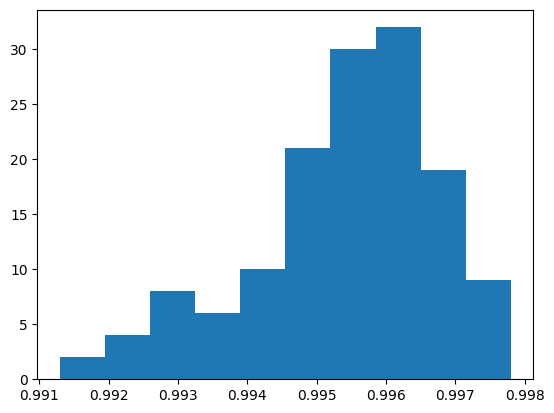

In [107]:
s00 = [item[0] for item in strat_0]
plt.hist(s00)

(array([ 3.,  2.,  1.,  3., 10., 16., 25., 49., 53., 24.]),
 array([0.98734868, 0.98837871, 0.98940874, 0.99043878, 0.99146881,
        0.99249884, 0.99352888, 0.99455891, 0.99558895, 0.99661898,
        0.99764901]),
 <BarContainer object of 10 artists>)

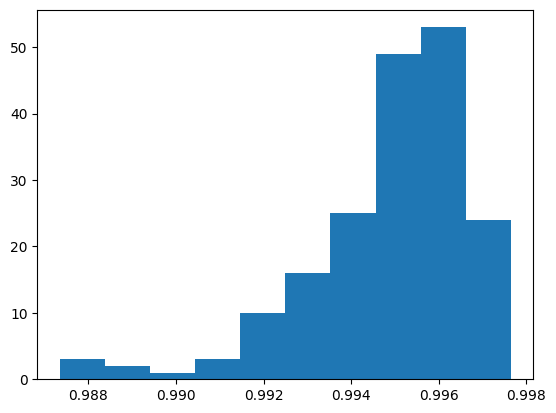

In [108]:
s10 = [item[0] for item in strat_1]
plt.hist(s10)

(array([ 2.,  2.,  3.,  3.,  3., 10., 11.,  9.,  6.,  2.]),
 array([0.98864567, 0.98955172, 0.99045777, 0.99136382, 0.99226987,
        0.99317592, 0.99408197, 0.99498802, 0.99589407, 0.99680012,
        0.99770617]),
 <BarContainer object of 10 artists>)

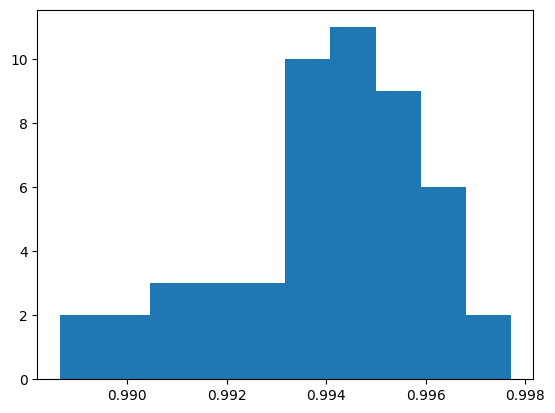

In [109]:
s20 = [item[0] for item in strat_2]
plt.hist(s20)

(array([ 13.,  72., 129., 108.,  99.,  61.,  17.,  13.,   2.,   1.]),
 array([0.07648688, 0.09734569, 0.1182045 , 0.13906332, 0.15992213,
        0.18078094, 0.20163976, 0.22249857, 0.24335738, 0.2642162 ,
        0.28507501]),
 <BarContainer object of 10 artists>)

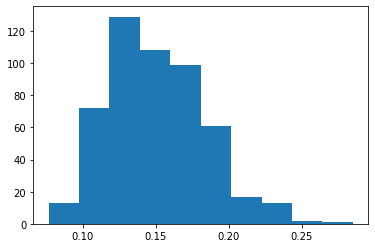

In [237]:
s01 = [item[1] for item in strat_0]
plt.hist(s01)

(array([  4.,  32.,  91., 189., 154., 108.,  39.,  24.,   1.,   2.]),
 array([0.08548212, 0.10813268, 0.13078323, 0.15343378, 0.17608434,
        0.19873489, 0.22138545, 0.244036  , 0.26668656, 0.28933711,
        0.31198767]),
 <BarContainer object of 10 artists>)

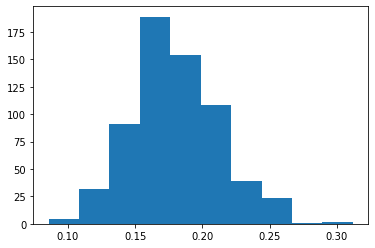

In [238]:
s11 = [item[1] for item in strat_1]
plt.hist(s11)

(array([ 1.,  1.,  5.,  8., 11., 13.,  4.,  6.,  2.,  2.]),
 array([0.11463587, 0.12875605, 0.14287623, 0.1569964 , 0.17111658,
        0.18523676, 0.19935694, 0.21347712, 0.22759729, 0.24171747,
        0.25583765]),
 <BarContainer object of 10 artists>)

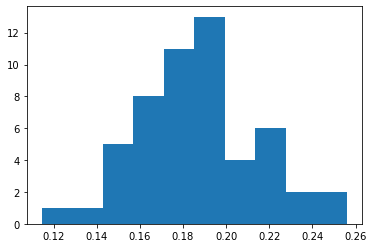

In [239]:
s21 = [item[1] for item in strat_2]
plt.hist(s21)

In [75]:
num_classes, num_sequences = 0, 0
seq_dataset = []
arr = []
    
split = [64, 128]
val = 0
data = pkl.load(open(os.path.join(out_dir, f'{journalist}_dict.pkl'), 'rb'))
#logging.info(f'loaded split aliceysu...')
num_classes = 3
num_sequences = len(set(data['conversation_id']))
journal = pd.DataFrame.from_dict(data)
#journal_sort = journal.sort_values(by=['created_at'])
#journal_batch = journal_sort[["type", "possibly_sensitive", "lang", "reply_settings",
#                              "retweet_count", "reply_count", "like_count", "quote_count", "impression_count",
#                              "mentions", "urls", "labels"]]
journal_sort = pd.read_csv(os.path.join(out_dir, f'{journalist}_context.csv'))

In [76]:
ids = list(set(journal_sort['conversation_id']))
id_pair = {}
id_conv = {}
for idx in ids:
    id_pair[idx], id_conv[idx] = create_conversation_list(journal_sort[journal_sort['conversation_id']==idx], idx)

In [67]:
with open(os.path.join(out_dir, f'{journalist}_global_path.txt')) as f:
    global_path = f.readlines()
    
with open(os.path.join(out_dir, f'{journalist}_local_path.txt')) as f:
    local_path = f.readlines()

In [7]:
global_dict = convert_path(global_path)

In [8]:
#journal_sort['global'] = [global_dict.get(str(id), global_dict[id]) for id in journal_sort['tweet_id']]
#journal_sort.to_csv(os.path.join(out_dir, f'{journalist}_context.csv'))
global_paths = [] # input
id_clean = {}
for i in ids:
    temp = []
    id_clean[i] = []
    for j, item in enumerate(id_conv[i]):
        if str(item) not in global_dict.keys():
            continue
        temp.append(global_dict[str(item)])
        id_clean[i].append(item)
    global_paths.append(temp)

In [54]:
# with open(os.path.join(out_dir, f'{journalist}_global_path.txt'), "w") as fout:
#     num_dps = 0
#     for k in id_pair.keys():
#         tree_root = build_tree(id_pair[k])
        
#         tree_root.create_global_relation()
#         node_list = tree_root.dfs()

#         root_paths = TreeNode.extract_data(node_list,f=lambda node: clamp_and_slice_ids(
#                 node.global_relation, max_width=-1, max_depth=-1))
#         asts = separate_dps(root_paths, n_ctx)

#         """for lr, extended in asts:
#             if extended != 0:
#                 break
#             if len(lr) - extended > 1:
#                 """
#         json.dump(root_paths, fp=fout)  # each line is the json of a list [dict,dict,...]
#         num_dps += 1
#         fout.write("\n")

In [218]:
# num_dps = 0
# with open(os.path.join(out_dir, f'{journalist}_local_path.txt'), "w") as fout:
#     for k in id_pair.keys():
#         tree_root = build_tree(id_pair[k])
        
#         tree_root.create_local_relation()
#         node_list = tree_root.dfs()

#         local_relation = TreeNode.extract_data(node_list,f=lambda node: clamp_and_slice_ids(
#                 node.local_relation, max_width=-1, max_depth=-1))
#         rel = separate_dps(local_relation, n_ctx)

#         """for lr, extended in rel:
#             if extended != 0:
#                 break
#             if len(lr) - extended > 1:"""
#         json.dump(local_relation, fp=fout)  # each line is the json of a list [dict,dict,...]
#         num_dps += 1
#         fout.write("\n")

In [77]:
out_fp = './result'
journalist = 'aliceysu'
n_ctx = 4000

In [78]:
batch_data = []
target_data = []
conv_data = []
ref_data = []
id_data = []
for idx in ids:
    convs = journal_sort[journal_sort['conversation_id'] == idx]
    convs_batch = convs[["type", "possibly_sensitive", "lang", "reply_settings",
                     "retweet_count", "reply_count", "like_count", "quote_count", "impression_count",
                     "mentions", "urls"]]
    conv_data.append(list(convs['conversation_id']))
    ref_data.append(list(convs['reference_id']))
    id_data.append(list(convs['tweet_id']))
    batch_data.append(convs_batch.values.tolist())
    target_data.append(list(convs['labels']))
    
label_data = target_data

In [19]:
position_data = []
for i, idx in enumerate(ids):
    tree_root = build_tree(id_pair[idx])
    node_info = get_node_info(tree_root)
    temp_list = []
    #temp_list.append([node_info[idx]['level'], node_info[idx]['number_of_siblings'], node_info[idx]['sibling_order']])
    for item in id_data[i]:
        """if item not in node_info.keys():
            continue"""
        temp_list.append([node_info[item]['level'], 
                    node_info[item]['number_of_siblings'], 
                    node_info[item]['sibling_order']])
    position_data.append(temp_list)

In [20]:
X_train, X_dev, X_test = batch_data[:split[0]], batch_data[split[0]:split[1]], batch_data[split[1]:]
pos_train, pos_dev, pos_test = position_data[:split[0]], position_data[split[0]:split[1]], position_data[split[1]:]
id_train, id_dev, id_test = id_data[:split[0]], id_data[split[0]:split[1]], id_data[split[1]:]
label_train, label_dev, label_test = label_data[:split[0]], label_data[split[0]:split[1]], label_data[split[1]:]

In [79]:
dp = []
with open(os.path.join(out_dir, f'{journalist}_global_path.txt'), "r") as f:
    for line in tqdm(f, total=get_number_of_lines(f)):
        dp.append(json.loads(line.strip()))
        
rel = []
with open(os.path.join(out_dir, f'{journalist}_local_path.txt'), "r") as f:
    for line in tqdm(f, total=get_number_of_lines(f)):
        rel.append(json.loads(line.strip()))

100%|██████████| 419/419 [00:00<00:00, 1124.90it/s]


In [80]:
roots = convert_global(dp, id_data)
local = convert_local(rel)

In [79]:
with open(os.path.join(out_dir, f'{journalist}_global_path.pkl'),'wb') as f:
    pickle.dump(roots, f)

In [236]:
## test
max_len = max(len(dp[0]) for dp in batch_data[:8])
max_depth = 12
max_width = 16
seqs = (id_data[:8], batch_data[:8], roots[:8])
r = []
for i in range(8):
    new_root = [roots[i][str(x)] for x in id_data[i]][:] + [[] for _ in range(max_len - len(id_data[i]))]
    r.append(new_root)
    
positions = generate_positions(r[1], max_width, max_depth)
position_seqs = []
positions = generate_positions(r[1], max_width=max_width, max_depth=max_depth)
position_seqs.append(positions.unsqueeze(0))

position_seqs[0].size()

KeyError: '4112'

In [123]:
local_mat = generate_local_mat(local, id_data)
local_input = create_mat(local_mat, mat_type='concat')

/u/yian3/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


## test functions

In [ ]:
def create_data(journal_sort, ids):
    batch_data = []
    target_data = []
    conv_data = []
    ref_data = []
    id_data = []
    for idx in ids:
        convs = journal_sort[journal_sort['conversation_id'] == idx]
        convs_batch = convs[['type', 'possibly_sensitive', 'lang', 'reply_settings', 
                               'retweet_count', 'reply_count', 'like_count', 'quote_count',
                                'impression_count', 'mentions', 'urls']]
        #conv_data.append(list(convs['conversation_id']))
        conv_data.append(convs_batch.to_numpy().tolist())
        ref_data.append(list(convs['reference_id']))
        id_data.append(list(convs['tweet_id']))
        batch_data.append(convs_batch.values.tolist())
        target_data.append(list(convs['labels']))
    
    label_data = target_data
    return id_data, conv_data, label_data

def load_data(data_dir, journalist, classes, batch_size, collate):
    ### Data (normalize input inter-event times, then padding to create dataloaders)
    num_classes, num_sequences = 0, 0
    seq_dataset = []
    arr = []
    dp = []
    rel = []
    
    split = [64, 128]
    val = 0
    journal_sort = pd.read_csv((os.path.join(data_dir, f'{journalist}_context.csv')))
    ids = list(set(journal_sort['conversation_id']))
    id_pair = {}
    id_conv = {}
    for idx in ids:
        id_pair[idx], id_conv[idx] = create_conversation_list(journal_sort[journal_sort['conversation_id']==idx], idx)
    id_data, data, label = create_data(journal_sort, ids)
    prob = pkl.load(open(os.path.join(data_dir, f'{journalist}_edgeprob.pkl'), 'rb'))
    
    with open(os.path.join(data_dir, f'{journalist}_global_path.txt'), "r") as f:
        for line in tqdm(f, total=get_number_of_lines(f)):
            dp.append(json.loads(line.strip()))

    with open(os.path.join(data_dir, f'{journalist}_local_path.txt'), "r") as f:
        for line in tqdm(f, total=get_number_of_lines(f)):
            rel.append(json.loads(line.strip()))
    
    global_input = convert_global(dp, id_data)
    local_data = convert_local(rel)
    local_mat = generate_local_mat(local_data, id_data)
    local_input = create_mat(local_mat, mat_type='concat')
    logging.info(f'loaded split {journalist}...')
    # data - dict: dim_process, devtest, args, train, dev, test, index (train/dev/test given as)
    # data[split] - list dicts {'time_since_start': at, 'time_since_last_event': dt, 'type_event': mark} or
    # data[split] - dict {'arrival_times', 'delta_times', 'marks'}
    # data['dim_process'] = Number of accounts = 119,298
    # num_sequences: number of conversations of a journalist
    num_classes = classes
    #num_sequences += len(data[split]['arrival_times'])
    num_sequences = len(set(journal_sort['conversation_id']))
    
    X_train, X_dev, X_test = data[:split[0]], data[split[0]:split[1]], data[split[1]:]
    prob_train, prob_dev, prob_test = prob[:split[0]], prob[split[0]:split[1]], prob[split[1]:]
    global_train, global_dev, global_test = global_input[:split[0]], global_input[split[0]:split[1]], global_input[split[1]:]
    local_train, local_dev, local_test = local_input[:split[0]], local_input[split[0]:split[1]], local_input[split[1]:]
    label_train, label_dev, label_test = label[:split[0]], label[split[0]:split[1]], label[split[1]:]

    d_train = TreeDataset(X_train, prob_train, global_train, local_train, label_train)
    d_val = TreeDataset(X_dev, prob_dev, global_dev, local_dev, label_dev)  
    d_test  = TreeDataset(X_test, prob_test, global_test, local_test, label_test)   

    # for padding input sequences to maxlen of batch for running on gpu, and arranging them by length efficient
    collate = collate  
    dl_train = torch.utils.data.DataLoader(d_train, batch_size=batch_size, shuffle=False, collate_fn=collate)
    dl_val = torch.utils.data.DataLoader(d_val, batch_size=batch_size, shuffle=False, collate_fn=collate)
    dl_test = torch.utils.data.DataLoader(d_test, batch_size=batch_size, shuffle=False, collate_fn=collate)
    return dl_train, dl_val, dl_test






In [ ]:
class TreeNodes:
    def __init__(self, name):
        self.name = name
        self.children = []  # List of TreeNode objects
        self.level = 0  # Level of the node in the tree
        self.sibling_order = 0  # Order among siblings
        self.parent = None  # Parent of the node
        self.local_relation = dict()
        self.global_relation = dict()

    def add_child(self, child_node):
        child_node.parent = self
        child_node.level = self.level + 1 if self.level is not None else 0
        child_node.sibling_order = len(self.children)
        self.children.append(child_node)

    def num_siblings(self):
        return len(self.parent.children)-1 if self.parent else 0
    
    def extract_data(node_list, only_leaf=False, f=lambda node: node.data):
        ret = []
        #print("?")
        for node in node_list:
            if not (only_leaf and node.node_type == "type"):
                ret.append({node.name: f(node)})
        return ret

    def create_local_relation(self):

        def _dfs(node):
            for child in node.children:
                node_child_rel = [child.level, child.num_siblings(), child.sibling_order]
                node_father_rel = [node.level, node.num_siblings(), node.sibling_order]
                #node_father_rel = child.parent
                node.local_relation[child.name] = [node_child_rel, node_father_rel, 0]
                child.local_relation[node.name] = [node_child_rel, node_father_rel, 1]
                _dfs(child)

        _dfs(self)

    def create_global_relation(self):
        def g_dfs(node):
            node_rel = [node.level, node.num_siblings(), node.sibling_order]
            if not node.parent:
                node.global_relation[node.name] = [node_rel]
            else: 
                if node.parent.name not in node.parent.global_relation.keys():
                    node.global_relation[node.name] = node.parent.parent.global_relation[node.parent.parent.name] + [node_rel]
                else:
                    node.global_relation[node.name] = node.parent.global_relation[node.parent.name] + [node_rel]
            for child in node.children:
                g_dfs(child)

        g_dfs(self)
 

    def dfs(self):
        ret = []

        def _dfs(node, ret):
           #ret : List
            ret.append(node)
            for child in node.children:
                _dfs(child, ret)

        _dfs(self, ret)
        return ret
    
def build_tree(conversations):
    nodes = {}
    root = 0

    for parent, child in conversations:
        if parent not in nodes:
            nodes[parent] = TreeNodes(parent)
        if child not in nodes:
            nodes[child] = TreeNodes(child)

        nodes[parent].add_child(nodes[child])

        if not root:
            root = nodes[parent]

    return root


def separate_dps(ast, max_len):
    """
    Handles training / evaluation on long ASTs by splitting
    them into smaller ASTs of length max_len, with a sliding
    window of max_len / 2.

    Example: for an AST ast with length 1700, and max_len = 1000,
    the output will be:
    [[ast[0:1000], 0], [ast[500:1500], 1000], [ast[700:1700], 1500]]

    Input:
        ast : List[Dictionary]
            List of nodes in pre-order traversal.
        max_len : int

    Output:
        aug_asts : List[List[List, int]]
            List of (ast, beginning idx of unseen nodes)
    """
    half_len = int(max_len / 2)
    if len(ast) <= max_len:
        return [[ast, 0]]

    aug_asts = [[ast[:max_len], 0]]
    i = half_len
    while i < len(ast) - max_len:
        aug_asts.append([ast[i: i + max_len], half_len])
        i += half_len
    idx = max_len - (len(ast) - (i + half_len))
    aug_asts.append([ast[-max_len:], idx])

    return aug_asts


def separate_lrs(lrs, max_len):
    def reformat(lrs, left):  # [left,right)
        new_lrs = []
        for idx, lr in enumerate(lrs):
            # lr -> dict: {idx:[],idx:[]}
            temp_lr = dict()
            for key, val in lr.items():
                if left <= key < left + max_len:
                    temp_lr[key - left] = val
            new_lrs.append(temp_lr)
        return new_lrs

    half_len = int(max_len / 2)
    if len(lrs) <= max_len:
        return [[reformat(lrs, 0), 0]]

    aug_asts = [[reformat(lrs[:max_len], 0), 0]]
    i = half_len
    while i < len(lrs) - max_len:
        aug_asts.append([reformat(lrs[i: i + max_len], i), half_len])
        i += half_len
    idx = max_len - (len(lrs) - (i + half_len))
    aug_asts.append([reformat(lrs[len(lrs) - max_len:], len(lrs) - max_len), idx])
    return aug_asts




In [ ]:
def convert_global(root_paths, id_data):
    roots = []
    global_new = []
    for i in range(len(root_paths)):
        new_dict = {}
        for item in root_paths[i]:
            name = list(item.keys())[0]
            new_dict[name] = np.array(list(list(item.values())[0].values())).squeeze().tolist()
        roots.append(new_dict)
    for i in range(len(id_data)):
        global_new.append([roots[i][str(k)] for k in id_data[i]])
    return global_new


def convert_local(local_rel):
    rel = []
    for i in range(len(local_rel)):
        new_dict = {}
        for item in local_rel[i]:
            name = list(item.keys())[0]
            new_dict[name] = item[name]
        rel.append(new_dict)
    return rel

def indexing(ls):
    dic = {}
    for i in range(len(ls)):
        dic[ls[i]] = i
        i += 1
    return dic

def generate_local_mat(local, idx):
    mat = []
    for ids, item in enumerate(local):
        #print(ids)
        temp = []
        ind = indexing(idx[ids])
        for i in idx[ids]:
            if str(i) not in list(local[ids].keys()):
                continue
            for k in list(local[ids][str(i)].keys()):
                if k == list(local[ids].keys())[0]:
                    temp_l = local[ids][str(i)][k]
                    temp_ind = ind[i]
                    temp.append([temp_ind, temp_ind, temp_l[temp_l[2]]])
                elif int(k) not in idx[ids]:
                    continue
                else:
                    temp_l = local[ids][str(i)][k]
                    temp_ind1 = ind[i]
                    temp_ind2 = ind[int(k)]
                    temp.append([temp_ind1, temp_ind2, temp_l[temp_l[2]]])
        if not temp:
            for i in idx[ids]:
                temp_ind = ind[i]
                temp.append([temp_ind, temp_ind, [0, 0, 0]])
        mat.append(temp)
    return mat
def create_mat(local_mat, mat_type):
    result = []
    for ind, item in enumerate(local_mat):
        max_row = max(i[0] for i in item)+1
        max_col = max(i[1] for i in item)+1
        if mat_type == 'sum':
            row = np.array(item)[:,0]
            col = np.array(item)[:,1]

            # taking data 
            data = np.array([sum(np.array(i)[2]) for i in item])

            # creating sparse matrix 
            sparseMatrix = csr_matrix((data, (row, col)), shape = (dim, dim)).toarray() 
            result.append(sparseMatrix)
        else:
            matrix = np.zeros((max_row, max_col, 3), dtype=float)
            for x in item:
                row, col, value = x
                matrix[row, col] = [i + 0.05 for i in value]
            result.append(matrix)
    return np.array(result)


In [ ]:
def pad_labels(labels, max_dim, pad_token=0):
    """Pad the label sequence to the maximum length."""
    max_length = max(len(seq) for seq in labels)
    if max_dim is not None and max_length > max_dim:
        max_length = max_dim
        
    return np.array([np.pad(seq, (0, max_length - len(seq)), mode='constant', constant_values=pad_token) 
                                 for seq in labels])

def pad_matrix(path, max_dim=None, pad_token=0):
    """Pad a 2D matrix to the specified max_length."""
    max_length = max(matrix.shape[0] for matrix in path)
    if max_dim is not None and max_length > max_dim:
        max_length = max_dim
        
    padded_matrices = []
    for matrix in path:
        truncated_matrix = matrix[:max_length, :max_length, :]
        padding = ((0, max(0, max_length - truncated_matrix.shape[0])), 
                   (0, max(0, max_length - truncated_matrix.shape[1])), 
                   (0, 0))
        adjusted_matrix = np.pad(truncated_matrix, pad_width=padding, mode='constant', constant_values=pad_token)
        padded_matrices.append(adjusted_matrix)

    return padded_matrices

def summ(paths):
    return [[list(map(sum, zip(*sub))) for sub in outer] for outer in paths]


class Batch():
    def __init__(self, data, labels, prob, global_path, local_path, masks):
        self.data = data
        self.labels = labels
        self.prob = prob
        self.global_path = global_path
        self.local_path = local_path
        self.masks = masks

def pad_sequences(sequences, max_dim=None, pad_token=0):
    # Determine the maximum sequence length
    max_length = max(len(seq) for seq in sequences)
    if max_dim is not None and max_length > max_dim:
        max_length = max_dim

    # Pad each sequence to the maximum length
    temp_seq = []
    for seq in sequences:
        if len(seq) >= max_length:
            temp_seq.append(seq[:max_length])
        else:
            temp_seq.append(seq)
    padded_sequences = np.array([np.pad(seq, ((0, max_length - len(seq)), (0, 0)), 
                                        mode='constant', constant_values=pad_token) 
                                 for seq in temp_seq])

    # Create attention masks
    attention_masks = np.array([[1 if token.any() else 0 for token in seq] 
                                for seq in padded_sequences])
    
    return padded_sequences, attention_masks

def collate(batch):
    batch_li = [list(item) for item in batch]
    data_temp = [row[0] for row in batch_li]
    labels_temp = [torch.Tensor(row[1]) for row in batch_li]
    prob_temp = [torch.Tensor(row[2]) for row in batch_li]
    global_path_temp = [row[3] for row in batch_li]
    local_path_temp = [row[4] for row in batch_li]
    

    padded_data, masks = pad_sequences(data_temp, max_dim=2000, pad_token=0)
    #padded_labels = pad_labels(labels_temp, max_dim=2000, pad_token=0)
    #padded_prob, _ = pad_sequences(prob_temp, max_dim=2000, pad_token=0)
    padded_global, _ = pad_sequences(summ(global_path_temp), max_dim=2000, pad_token=0)
    padded_local = pad_matrix(local_path_temp, max_dim=2000, pad_token=0)

    data= torch.tensor(padded_data).to(torch.int64)
    #labels = torch.tensor(padded_labels).to(torch.int64)
    #prob = torch.tensor(padded_prob).to(torch.int64)
    global_path = torch.tensor(padded_global).to(torch.int64)
    local_path = torch.tensor(padded_local).to(torch.int64)
    labels = torch.nn.utils.rnn.pad_sequence(labels_temp, batch_first=True)
    prob = torch.nn.utils.rnn.pad_sequence(prob_temp, batch_first=True)
    #global_path = torch.nn.utils.rnn.pad_sequence(global_path_temp, batch_first=True)
    #local_path = torch.nn.utils.rnn.pad_sequence(local_path_temp, batch_first=True)
    #print(masks)
    
    #out_tweet_type = torch.nn.utils.rnn.pad_sequence(out_tweet_types, batch_first=True)
    #print("start")
    return Batch(data, labels, prob, global_path, local_path, torch.tensor(masks))

In [ ]:
class TreeNode:
    def __init__(self, name):
        self.name = name
        self.children = []  # List of TreeNode objects
        self.level = 0  # Level of the node in the tree
        self.sibling_order = 0  # Order among siblings
        self.parent = None  # Parent of the node
        self.local_relation = dict()
        self.global_relation = dict()
        

    def add_child(self, child_node):
        child_node.parent = self
        child_node.level = self.level + 1 if self.level is not None else 0
        child_node.sibling_order = len(self.children)
        self.children.append(child_node)

    def num_siblings(self):
        return len(self.parent.children)-1 if self.parent else 0
    
    def extract_data(node_list, only_leaf=False, f=lambda node: node.data):
        ret = []
        for node in node_list:
            if not (only_leaf and node.node_type == "type"):
                ret.append(f(node))
        return ret

    def create_local_relation(self):
        def _dfs(node):
            for child in node.children:
                node_child_rel = [child.level, child.num_siblings(), child.sibling_order]
                node_father_rel = [node.level, node.num_siblings(), node.sibling_order]
                
                node.local_relation[child.name] = [node_child_rel, node_father_rel, 0]
                child.local_relation[node.name] = [node_child_rel, node_father_rel, 1]
                _dfs(child)

        _dfs(self)
    
    def create_global_relation(self):
        def g_dfs(node):
            node_rel = [node.level, node.num_siblings(), node.sibling_order]
            if not node.parent:
                node.global_relation[node.name] = [node_rel]
            else: 
                if node.parent.name not in node.parent.global_relation.keys():
                    node.global_relation[node.name] = node.parent.parent.global_relation[node.parent.parent.name] + [node_rel]
                else:
                    node.global_relation[node.name] = node.parent.global_relation[node.parent.name] + [node_rel]
            for child in node.children:
                g_dfs(child)

        g_dfs(self)
        #return 

    def dfs(self):
        ret = []

        def _dfs(node, ret):
           #ret : List
            ret.append(node)
            for child in node.children:
                _dfs(child, ret)

        _dfs(self, ret)
        return ret
    
def build_tree(conversations):
    nodes = {}
    root = 0

    for parent, child in conversations:
        if parent not in nodes:
            nodes[parent] = TreeNode(parent)
        if child not in nodes:
            nodes[child] = TreeNode(child)
        nodes[parent].add_child(nodes[child])

        if not root:
            root = nodes[parent]

    return root

def get_node_info(tree_root):
    node_info = {}

    def traverse(node):
        node_info[node.name] = {
            'level': node.level,
            'number_of_siblings': node.num_siblings(),
            'sibling_order': node.sibling_order,
        }
        for child in node.children:
            traverse(child)

    traverse(tree_root)
    return node_info


## Mukhil's code

In [2]:
# aliceysu
# bainjal
users = []
journalist = 'aliceysu'
user_id = '24709718'
data_dir = '../desktop/'
path = os.path.join(data_dir, f'tweets_in_{journalist}_started_convs.json')
# '../desktop/tweets_in_aliceysu_started_convs.json'
with open(path) as f:
    for line in f:
        #print(line)
        users.append(json.loads(line))
    #users = [json.loads(line) for line in f]

In [3]:
data = users[0]
user_ids = set()
for i in range(len(data)):  
    user_ids.add(data[i]['conversation_id'])
print(len(user_ids))

420


In [28]:
data[0]

{'possibly_sensitive': False,
 'lang': 'qme',
 'conversation_id': '1603565869673873408',
 'referenced_tweets': [{'type': 'replied_to', 'id': '1603565869673873408'}],
 'edit_history_tweet_ids': ['1608261522870136833'],
 'reply_settings': 'everyone',
 'created_at': '2022-12-29T00:40:01.000Z',
 'public_metrics': {'retweet_count': 0,
  'reply_count': 0,
  'like_count': 0,
  'quote_count': 0,
  'impression_count': 3},
 'entities': {'urls': [{'start': 10,
    'end': 33,
    'url': 'https://t.co/stR6weHTUO',
    'expanded_url': 'https://rumble.com/v21y3qs-covid-19-vaccines-what-they-are-how-they-work-and-possible-causes-of-injuri.html',
    'display_url': 'rumble.com/v21y3qs-covid-…',
    'images': [{'url': 'https://pbs.twimg.com/news_img/1623388282397630467/SN1aV-kE?format=jpg&name=orig',
      'width': 1280,
      'height': 720},
     {'url': 'https://pbs.twimg.com/news_img/1623388282397630467/SN1aV-kE?format=jpg&name=150x150',
      'width': 150,
      'height': 150}],
    'status': 200,
 

In [4]:
people = set()
tweets = []
for i in range(len(data)):
    if (data[i]['conversation_id'] in user_ids):
        people.add(data[i]['author_id'])
        tweets.append(data[i]['author_id'])
print(len(people))
print(len(tweets))

6925
10685


In [5]:
######### INITIALISAING ACTIVITY TRACE DICTIONARY #########
activity_traces = {}
for element in user_ids:
    activity_traces[element] = []

In [6]:
date_format = "%Y-%m-%dT%H:%M:%S" 
datetime.strptime(data[0]['created_at'][:19], date_format)

datetime.datetime(2022, 12, 29, 0, 40, 1)

In [7]:
######### ACCUMLATING TWEETS UNDER THEIR CONVERSATION ID #########
count = 0
for i in range(len(data)):
    conversation_id = data[i]['conversation_id']
    if conversation_id in user_ids:
        if 'referenced_tweets' in data[i]:
            if data[i]['referenced_tweets'][0]['type'] == 'replied_to':
                if [data[i]['id'], datetime.strptime(data[i]['created_at'][:19], date_format), data[i]['author_id'], 1] in activity_traces[conversation_id]:
                    count += 1
                else:
                    activity_traces[conversation_id].append([data[i]['id'], datetime.strptime(data[i]['created_at'][:19], date_format), data[i]['author_id'], 1])
            elif data[i]['referenced_tweets'][0]['type'] == 'quoted':
                if [data[i]['id'], datetime.strptime(data[i]['created_at'][:19], date_format), data[i]['author_id'], 2] in activity_traces[conversation_id]:
                    count += 1
                else:
                    activity_traces[conversation_id].append([data[i]['id'], datetime.strptime(data[i]['created_at'][:19], date_format), data[i]['author_id'], 2])
        else:
            if [data[i]['id'], datetime.strptime(data[i]['created_at'][:19], date_format), data[i]['author_id'], 0] in activity_traces[conversation_id]:
                count += 1
            else:
                activity_traces[conversation_id].append([data[i]['id'], datetime.strptime(data[i]['created_at'][:19], date_format), data[i]['author_id'], 0])
            
# 0 for original tweet, 1 for reply to another tweet, 2 for quoted tweet.
# 54607 duplicated
print(count)

0


In [15]:
activity_traces['1603565869673873408']

[['1608261522870136833',
  datetime.datetime(2022, 12, 29, 0, 40, 1),
  '1519143967886954496',
  1],
 ['1603751795553361921',
  datetime.datetime(2022, 12, 16, 13, 59, 58),
  '2411054094',
  1],
 ['1603566654969245696',
  datetime.datetime(2022, 12, 16, 1, 44, 18),
  '51081835',
  1]]

In [16]:
######### SORTING WITHIN AN ACTIVITY TRACE BASED ON TIME #########
sorted_activity_trace_dirty = []
for key in activity_traces:
    sorted_activity_trace_dirty.append(sorted(activity_traces[key], key=lambda d: d[1]))

In [17]:
######### REMOVING ACTIVITY TRACES THAT ARE OF LENGTH ONE OR LESS #########
index = []
sorted_activity_trace = []
for i in range(len(sorted_activity_trace_dirty)):
    if len(sorted_activity_trace_dirty[i]) > 1:
        sorted_activity_trace.append(sorted_activity_trace_dirty[i]) 

In [27]:
len(sorted_activity_trace_dirty)

420

In [18]:
######### CREATING USER ID MAPPING AND THE REVERSE MAPPING TO OBTAIN INPUT MARKS VALUES AND DECODE THEM #########
ents = []
for actTrace in sorted_activity_trace:
    for act in actTrace:
        ents.append(act[2])

idmap = {}
other_way = {}
for idx, ent in enumerate(set(ents)):
    idmap[ent] = idx
    other_way[idx] = ent



In [19]:
numTraces = len(sorted_activity_trace)

np.random.shuffle(sorted_activity_trace)

valTraces = sorted_activity_trace[:int(0.1*numTraces)]
testTraces = sorted_activity_trace[int(0.1*numTraces):int(0.2*numTraces)]
trainTraces = sorted_activity_trace

In [21]:
split = {}
cols = ['arrival_times', 'delta_times', 'marks', 'tweet_type']

for col in cols:
    split[col] = []

tweetSeqMap = {}
lengths = []

for idx, activityTrace in enumerate(trainTraces): 
    #assert int(activityTrace[0][2]) == userId
    
    starts = [act[1] for act in activityTrace]
    iStart = starts[0]
    
    normStarts = [ (act[1] - iStart).total_seconds()/(24*3600) for act in activityTrace]
    assert normStarts[0] == 0
    deltaTimes = [1.0] 
    for i in range(1,len(normStarts)):
        deltaTimes.append(normStarts[i] - normStarts[i-1] )
        
    marks = []
    for i in range(len(normStarts)):
        marks.append(idmap[activityTrace[i][2]])
    
    tweet_type = []
    for i in range(len(normStarts)):
        tweet_type.append(activityTrace[i][3])
        
    tweetSeqMap[activityTrace[0][0]] = idx
    lengths.append(len(normStarts))
    split['arrival_times'].append(normStarts)
    split['delta_times'].append(deltaTimes)
    split['marks'].append(marks)
    split['tweet_type'].append(tweet_type)

In [22]:
split1 = {}
for col in cols:
    split1[col] = []
for idx, activityTrace in enumerate(testTraces): 
    #assert int(activityTrace[0][2]) == userId
    
    starts = [act[1] for act in activityTrace]
    iStart = starts[0]
    
    normStarts = [ (act[1] - iStart).total_seconds()/(24*3600) for act in activityTrace]
    assert normStarts[0] == 0
    deltaTimes = [1.0] 
    for i in range(1,len(normStarts)):
        deltaTimes.append( normStarts[i] - normStarts[i-1] )
        
    marks = []
    for i in range(len(normStarts)):
        marks.append(idmap[activityTrace[i][2]])
        
    tweet_type = []
    for i in range(len(normStarts)):
        tweet_type.append(activityTrace[i][3])
        
    tweetSeqMap[activityTrace[0][0]] = idx
    
    split1['arrival_times'].append(normStarts)
    split1['delta_times'].append(deltaTimes)
    split1['marks'].append(marks)
    split1['tweet_type'].append(tweet_type)

In [25]:
split2 = {}

for col in cols:
    split2[col] = []
for idx, activityTrace in enumerate(valTraces): 
    #assert int(activityTrace[0][2]) == userId
    
    starts = [act[1] for act in activityTrace]
    iStart = starts[0]
    
    normStarts = [ (act[1] - iStart).total_seconds()/(24*3600) for act in activityTrace]
    assert normStarts[0] == 0
    deltaTimes = [1.0] 
    for i in range(1,len(normStarts)):
        deltaTimes.append( normStarts[i] - normStarts[i-1] )
        
    marks = []
    for i in range(len(normStarts)):
        marks.append(idmap[activityTrace[i][2]])
        
    tweet_type = []
    for i in range(len(normStarts)):
        tweet_type.append(activityTrace[i][3])
    tweetSeqMap[activityTrace[0][0]] = idx

    split2['arrival_times'].append(normStarts)
    split2['delta_times'].append(deltaTimes)
    split2['marks'].append(marks)
    split2['tweet_type'].append(tweet_type)

In [24]:
data_result = {}
data_result["train"] = split
data_result["test"] = split1
data_result["dev"] = split2
data_result['dim_process'] = len(ents)

In [20]:
data_result['dev']

{'arrival_times': [[0.0, 2.527210648148148],
  [0.0, 0.0014467592592592592],
  [0.0, 0.03166666666666667, 30.01508101851852, 437.3130092592593],
  [0.0, 0.14180555555555555],
  [0.0,
   0.006423611111111111,
   0.01766203703703704,
   0.02746527777777778,
   0.07740740740740741,
   0.08822916666666666,
   0.19037037037037038,
   0.4257523148148148,
   0.5247685185185185,
   0.5637152777777777,
   0.66875,
   1.6597337962962964,
   1.6610763888888889,
   1.7932291666666667],
  [0.0,
   0.09506944444444444,
   0.3719675925925926,
   0.421875,
   0.8337037037037037,
   1.1365277777777778,
   3.1604282407407407,
   3.6797569444444442,
   6.233449074074074],
  [0.0, 0.22703703703703704, 1.990324074074074, 2.297083333333333],
  [0.0,
   0.0030555555555555557,
   0.3507986111111111,
   0.6315046296296296,
   2.8250462962962963],
  [0.0,
   0.0012731481481481483,
   0.004340277777777778,
   0.005613425925925926,
   0.012326388888888888,
   0.01238425925925926,
   0.014293981481481482,
   0.014

In [1]:
import pickle
with open ('kdd_data/attempt_dev.pkl', 'rb') as f:
    att = pickle.load(f)

In [4]:
att['dev'].keys()

dict_keys(['arrival_times', 'delta_times', 'marks', 'tweet_type'])

In [150]:
max_len = 0
for i in split['arrival_times']:
    if len(i) > max_len:
        max_len = len(i)

In [151]:
max_len

3252